Implementación de métricas de evualuación de la mejora conseguida en el contraste.

In [1]:
# Importar librerías

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir, path

In [2]:
# Función para la lectura de imágenes

def read_images(directory, allow_color_images=False):
    """
    Lee todas las imágenes en un directorio

    Parámetros

    directory: str
        Directorio con las imágenes
    allow_color_images: bool
        Permite el uso de imágenes a color

    Retorna

    images: list
        Lista con las imágenes
    """
    # Leer todas las imágenes en el directorio
    images = []
    for f in listdir(directory):
        if f.endswith('.jpg') or f.endswith('.png'):
            image = cv2.imread(path.join(directory, f), cv2.IMREAD_GRAYSCALE)
            if allow_color_images:
                image = cv2.imread(path.join(directory, f), cv2.IMREAD_COLOR)
            images.append(image)
    return images

1. **Contrast (C)**:
   - Esta métrica cuantifica el contraste global de las imágenes en escala de grises.
   - La fórmula para el cálculo del contraste es:
     $$ C(f) = \sqrt{\sum_{j=0}^{L-1} (j - E(f))^2 \times P(j)} $$
     Donde:
     - \( j \) representa el valor del píxel en la imagen.
     - \( L \) son los niveles de grises.
     - \( E(f) \) es la intensidad media de la imagen.
     - \( P(j) \) es la probabilidad de ocurrencia del valor \( j \).
   - Para evaluar la mejora del contraste, el valor \( C(f_E) \) de la imagen resultante debe ser mayor que \( C(f) \) de la imagen original.

2. **Contrast Improvement Ratio (CIR)**:
   -  La métrica adoptada para evaluar la mejora del contraste local de la imagen en escala de grises se denomina Contrast Improvement Ratio (CIR). El contraste local se define como la diferencia de los valores medios en dos ventanas rectangulares centradas en un píxel. Específicamente, el contraste local w(u, v) se define como:  
   $w(u, v) = \frac{|p - l|}{|p + l|}$

donde p y l  son los valores de los niveles de grises del píxel central y la media del los vecinos dentro de una ventana de 3 x 3. Da la medida de contraste en el rango [0,1].

   - Esta métrica evalúa la mejora del contraste local de la imagen en escala de grises.
   - La fórmula para el cálculo de CIR es:
     $$CIR(f, f_E) = \frac{\sum_{(u,v) \in D} |w(u, v) - \tilde{w}(u, v)|^2}{\sum_{(u,v) \in D} w(u, v)^2} $$
     Donde:
     - $( w(u, v) )$ y $( \tilde{w}(u, v) )$ son los valores de contraste locales de las imágenes original y mejorada, respectivamente.
     - $( D )$ es el dominio de la imagen.
   - Esta fórmula mide la diferencia entre los pesos de los píxeles en la imagen original y la imagen filtrada, normalizando la contribución de los pesos originales.
   - El numerador mide la diferencia entre los pesos de los píxeles en la imagen original y la imagen filtrada, mientras que el denominador normaliza la contribución de los pesos originales.

3. **PSNR (Peak Signal-to-Noise Ratio)**:
   - Esta medida compara la calidad de la imagen.
   - La fórmula para el cálculo de PSNR es:
     $$PSNR = 10 \log_{10} \left( \frac{\sum_{x} \sum_{y}  255^2}{ \sum_{x} \sum_{y} \left\{  f(x, y) - f_{En}(x, y)\right\}^2} \right)$$
     Donde:
     - $( f )$ y $( f_{En} )$ representan la imagen original y la imagen mejorada, respectivamente.
   - Un valor mayor de PSNR indica una mejor mejora de la imagen y menos ruido.

4. **Índice lineal de borrosidad (γ)**:
   - Esta medida se utiliza para comparar la claridad de una imagen mejorada.
   - La fórmula para el cálculo de \( \gamma \) es:
     $$ \gamma(f_{En}) = \frac{2}{MN} \sum_{x=1}^{m} \sum_{y=1}^{n} \min\{ p_{xy}, (1 - p_{xy}) \} $$
     Donde:
     - $( p_{xy} = \sin \left[ \frac{\pi}{2} \times \left( 1 - \frac{f(x,y)}{f_{\text{max}}} \right) \right] )$
     - $( f_{\text{max}} )$ es el valor máximo de gris de $( f_{En} )$.
   - Un valor menor de $( \gamma )$ indica una mejor claridad de la imagen mejorada.

5. **PL (Picture Level)**:
   - Esta medida combina PSNR y $( \gamma )$ para medir tanto la condición de ruido como la claridad de la imagen mejorada.
   - La fórmula para el cálculo de PL es:
     $$ PL = \frac{PSNR}{\gamma} $$
   - Un valor mayor de PL indica menos ruido y una imagen mejorada más clara.

Espero que estas descripciones te ayuden a implementar las métricas de evaluación de mejora de contraste de imágenes EL en escala de grises utilizando Python. Si necesitas más ayuda con la implementación específica de alguna de estas métricas, no dudes en preguntar.

In [3]:
# Función para medir la métrica Contrast en imágenes en escala de grises
def contrast_metric(image):
    # Calcular la intensidad media de la imagen
    E = np.mean(image)

    # Obtener el número de niveles de grises (L)
    num_gray_levels = np.max(image) + 1

    # Calcular la probabilidad de ocurrencia de cada valor de píxel
    hist, _ = np.histogram(image, bins=num_gray_levels, range=(0, num_gray_levels))
    P = hist / float(np.sum(hist))

    # Calcular el contraste
    C = np.sqrt(np.sum([(j - E)**2 * P[j] for j in range(num_gray_levels)]))

    return C

# Función para medir la métrica contrast Improvement ratio (CIR) en imágenes en escala de grises
def CIR(original_image, enhanced_image):
    M, N = original_image.shape
    numerator_sum = 0
    denominator_sum = 0

    for u in range(1, M-1):
        for v in range(1, N-1):
            # Calcular la media de los vecinos para la imagen original y la mejorada
            mean_original = np.mean(original_image[u-1:u+2, v-1:v+2])
            mean_enhanced = np.mean(enhanced_image[u-1:u+2, v-1:v+2])

            # Calcular el contraste local para la imagen original
            denominator_original = original_image[u, v] + mean_original
            w_original = abs(original_image[u, v] - mean_original) / denominator_original if denominator_original != 0 else 0
            
            # Calcular el contraste local para la imagen mejorada
            denominator_enhanced = enhanced_image[u, v] + mean_enhanced
            w_enhanced = abs(enhanced_image[u, v] - mean_enhanced) / denominator_enhanced if denominator_enhanced != 0 else 0

            # Actualizar las sumas para el numerador y el denominador
            numerator_sum += (w_original - w_enhanced)**2
            denominator_sum += w_original**2

    # Calcular el CIR
    CIR = numerator_sum / denominator_sum if denominator_sum != 0 else 0

    return CIR

# Función para calcular el PSNR entre las imágenes original y mejorada
def PSNR(original_image, enhanced_image):
    # Calcular el error cuadrático medio
    mse = np.mean((original_image - enhanced_image)**2)
    print("max_pixel", np.max(original_image))

    # Calcular el PSNR
    psnr = 10 * np.log10((255**2) / mse)

    return psnr

# Función para calcular el ínidice de borrosidad en imágenes en escala de grises
def blur_metric(enhanced_image):
    # Calcular el índice de borrosidad
    M, N = enhanced_image.shape
    p_xy = np.sin(np.pi / 2 * (1 - enhanced_image / np.max(enhanced_image)))
    blur_index = (2 / (M * N)) * np.sum(np.minimum(p_xy, (1 - p_xy)))
    return blur_index

# Función para calcular PL metric en imágenes en escala de grises
def PL(original_image, enhanced_image):
    psnr = PSNR(original_image, enhanced_image)
    blur = blur_metric(enhanced_image)

    # Calcular PL
    PL = psnr / blur
    return PL


In [5]:
# Ruta de las imágenes
image_path = "E:/Panel_30W/P13/V24.2_I2.50_t30/JPEG_8"
background_path ="E:/Panel_30W/P13/V24.2_I2.50_t30/fondo_8/JPEG_fondo_8"
No_background_path = "E:/Panel_30W/Salida13/P8/dataset_noBG"
imagePP_path = "E:/Panel_30W/Salida13/P8bg"
image1_2Isc_path = "E:/Panel_30W/P13/V22.1_I0.9_t27.973/JPEG"

datasetEL = read_images(image_path)
datasetBG = read_images(background_path)
dataset_noBG = read_images(No_background_path)
datasetPP = read_images(imagePP_path)

# Imprime el número de imágenes en cada dataset
# para probar que las imágenes se agregaron
print("Imágenes en el dataset EL: ", len(datasetEL))
print("Imágenes en el dataset BG: ", len(datasetBG))
print("Imágenes en el dataset noBG: ", len(dataset_noBG))
print("Imágenes en el dataset PP: ", len(datasetPP))

Imágenes en el dataset EL:  51
Imágenes en el dataset BG:  51
Imágenes en el dataset noBG:  51
Imágenes en el dataset PP:  5


In [6]:
# Evaluación de la métrica CIR en la primera imágen

CIR_value = CIR(datasetEL[0], datasetPP[0])
print("CIR de la primera imagen: ", CIR_value)

C:\Users\Compustore\AppData\Local\Temp\ipykernel_9348\1670235962.py:31: RuntimeWarning: invalid value encountered in scalar divide
  w_original = abs(original_image[u, v] - np.mean(original_image[u-1:u+2, v-1:v+2])) / (original_image[u, v] + np.mean(original_image[u-1:u+2, v-1:v+2]))


CIR de la primera imagen:  nan


Contraste promedio en imágenes de datasetPP:  59.621560537612844
Contraste promedio en imágenes de datasetEL:  49.1287973522965


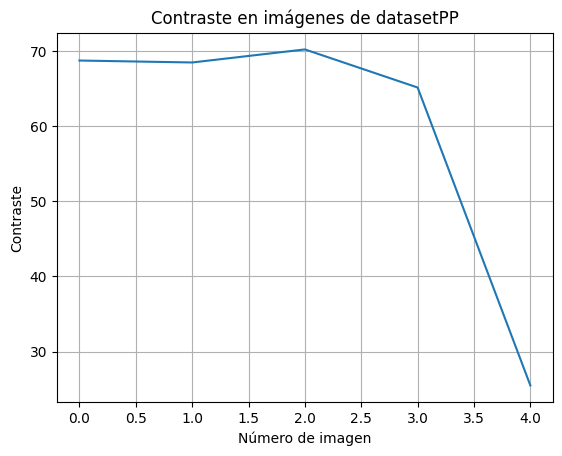

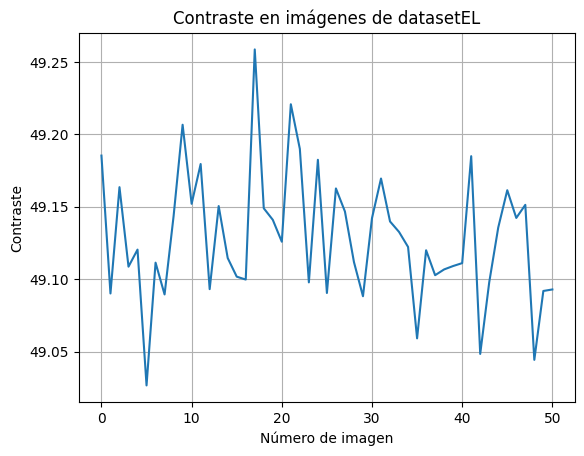

In [10]:
# Evaluación de la métrica de contraste en las imágenes de datasetPP

contrast_values = []
for image in datasetPP:
    contrast_values.append(contrast_metric(image))

print("Contraste promedio en imágenes de datasetPP: ", np.mean(contrast_values))

# Evaluación de la métrica de contraste en las imágenes de datasetEL

contrast_valuesEL = []
for image in datasetEL:
    contrast_valuesEL.append(contrast_metric(image))

print("Contraste promedio en imágenes de datasetEL: ", np.mean(contrast_valuesEL))



# Graficar los valores de contraste datasetPP
plt.figure()
plt.plot(contrast_values)
plt.xlabel('Número de imagen')
plt.ylabel('Contraste')
plt.title('Contraste en imágenes de datasetPP')
plt.grid()
plt.show()

# Graficar los valores de contraste datasetEL
plt.figure()
plt.plot(contrast_valuesEL)
plt.xlabel('Número de imagen')
plt.ylabel('Contraste')
plt.title('Contraste en imágenes de datasetEL')
plt.grid()
plt.show()
